# Fitting first-level fMRI GLMs with nilearn

- Author: Andrew J. Graves
- Date: 9/21/22

In [1]:
# Import modules
import pickle
import numpy as np
import matplotlib.pyplot as plt

import nilearn
from nilearn.glm.first_level import first_level_from_bids
from nilearn.image import concat_imgs
from nilearn.plotting import plot_design_matrix, plot_glass_brain

# Specify BIDS directory (niftis AND events must be in BIDS)
# Assumes bids_dir contains subdirectory 'derivatives'
bids_dir = '/project/morrislab/fmriprep_in/epigene_v3'

# Specify name of task in BIDS files 
task_label = 'faceflower'

# Extra events in your design matrix that you would like to remove
# None is an option here
extra_ev_cols = ['resp_type']

# Specify number of cores for each subject (# requested from HPC, important!)
# Within-subjects/ runs is parallelized but between-subjects is serial
# in this implementation
n_cores = 16

# Fit an additional set of models w/ single-trial beta coefficients 
also_fit_single_trial_betas = True

# For high-resolution plot display
plt.rcParams['figure.dpi'] = 300

# Particularly important because glm module is subject to significant change
print(f'nilearn version: {nilearn.__version__}')

nilearn version: 0.9.2


/home/ajg3eh/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


- *bids_dir* and *task_label* are clearly study-specific and should be changed to match your own projects. *bids_dir* must contain BIDS-compliant event .tsv files, as well as a sub-directory named *derivatives* that contains BIDS-formatted (ideally fmriprep output) pre-processed niftis to work smoothly.

## Set first-level parameters

The next cell contain all the parameters you will need to specify for your first-level models. You likely will not need to change any of these, unless you configured your fmriprep runs differently (e.g., different output template, different slice-time reference, etc.). They are included here outside of the function call for simple changes if you would like to make modifications.

In [2]:
# Set parameters for first-level model -----

# Set slice time reference (fmriprep default output is 0.5)
st_ref = 0.5
# Specify desired hemodynamic response function for convolution
# 'glover' is a canonical double-gamma and the default
hrf = 'glover'

# Specify type and order of drift parameters 
# ---
# Specify None if using fmriprep cosine drift outputs
drift_model = 'polynomial'
# Set high-pass filter cutoff (ignored if drift_model = None / 'polynomial')
hp_cutoff = .008
# Number of drift regressors (ignored if drift_model = None)
drift_order = 3
# ---

# Whether or not to perform smoothing at first-level
perform_first_level_smoothing = False
# Size of smoothing if desired
fwhm_size = 5
# Specify noise model type (default is ar1)
noise = 'ar1'
# Control print behavior (options: 0, 1, 2)
verbosity = 1
# Specify string patterns for image files to extract from derivatives folder
# 'desc' and 'preproc' are the default for fmriprep output
img_flags = [
    ('desc', 'preproc')
]
# Standardized output space template from fmriprep 
space = 'MNI152NLin2009cAsym'

# Subset confounds (up to researcher's discretion!)

# Ideally these columns exist for every subject / run because it is
# easier to specify lists of contrast vectors later, and so that each image is 
# "treated the same". This subset happened to be present in every image file 
# for my experiments, and is sufficient cleaning for AR estimation. 

conf_subset = [
    # Segmentation signals ---
    'csf',
    'white_matter',
    
    # Noise decomposition components ---
    # 't' prefix indicates high variance voxel mask
    'tcompcor',
    # 'a' prefix indicates anatomical mask
    'a_comp_cor_00',
    'a_comp_cor_01',
    
    # Motion ---
    'trans_x',
    'trans_x_power2',
    'trans_y',
    'trans_y_power2',
    'trans_z',
    'trans_z_power2',
    'rot_x',
    'rot_x_power2',
    'rot_y',
    'rot_y_power2',
    'rot_z',
    'rot_z_power2'
]

# -----

# Fit first-level models

Now that parameters have been defined, there is no need to modify the following cell. The *first_level_from_bids* functions takes BIDS-compliant (ideally fmriprep output) pre-processed data and organizes the niftis, events, and confounds for all subjects and runs. Then linear least-squares models are fit to every voxel individually using autoregressive noise structure to account for the sequential dependencies of successive volumes. 

- Note that the warning about SliceTimingRef can be safely ignored because we have specified it explicitly in the model function call.

In [3]:
# Control-flow for first-level smoothing
if perform_first_level_smoothing:
    fwhm = fwhm_size
else:
    fwhm = None

# Collect all first level model information using specified parameters
# See ?first_level_from_bids to read documentation on each argument
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        bids_dir, task_label,
        slice_time_ref=st_ref,
        hrf_model=hrf,
        high_pass=hp_cutoff,
        drift_model=drift_model,
        drift_order=drift_order,
        smoothing_fwhm=fwhm,
        noise_model=noise,
        verbose=verbosity,
        n_jobs=n_cores,
        img_filters=img_flags,
        space_label=space
)

# Iterete through the subject/run nested lists
for subj_idx, subj in enumerate(models_confounds):
    for run_idx, run in enumerate(subj):
        # Get subset of confounds
        models_confounds[subj_idx][run_idx] = run.iloc[:, 
                                                run.columns.isin(conf_subset)]
        # Remove extra event columns (if they are specified)
        try:
            models_events[subj_idx][run_idx].drop(extra_ev_cols, 
                                                  axis=1, inplace=True)
        except:
            print('No extra columns in events design matrix were dropped.')

# Zip together model inputs
model_args = zip(models, models_run_imgs, models_events, models_confounds)

# Initialize model output
first_level_models = []
# Iterate through all subjects and runs
print(f'Fitting single-subject GLMs for {task_label} task: \n')
for model, imgs, events, confounds in model_args:
    # Fit the first-level models
    model.fit(imgs, events, confounds)
    # Add to first-level output
    first_level_models.append(model)
    print(f'Completed fitting subject {model.subject_label}')
    
# Save out first-level models to file
with open(f'first_level_models_{task_label}.pkl', 'wb') as handle:
    pickle.dump(first_level_models, handle, 
                protocol=pickle.HIGHEST_PROTOCOL)

/home/ajg3eh/.local/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:940: UserWarning: SliceTimingRef not found in file /project/morrislab/fmriprep_in/epigene_v3/derivatives/sub-268/ses-01/func/sub-268_ses-01_task-faceflower_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


Fitting single-subject GLMs for faceflower task: 



Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (76 seconds remaining)
Computing run 3 out of 3 runs (38 seconds remaining)

Computation of 3 runs done in 113 seconds



Completed fitting subject 268


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (63 seconds remaining)
Computing run 3 out of 3 runs (31 seconds remaining)

Computation of 3 runs done in 94 seconds



Completed fitting subject 269


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (64 seconds remaining)
Computing run 3 out of 3 runs (31 seconds remaining)

Computation of 3 runs done in 97 seconds



Completed fitting subject 270


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (64 seconds remaining)
Computing run 3 out of 3 runs (32 seconds remaining)

Computation of 3 runs done in 97 seconds



Completed fitting subject 271


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (70 seconds remaining)
Computing run 3 out of 3 runs (35 seconds remaining)

Computation of 3 runs done in 107 seconds



Completed fitting subject 272


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (70 seconds remaining)
Computing run 3 out of 3 runs (35 seconds remaining)

Computation of 3 runs done in 105 seconds



Completed fitting subject 273


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (69 seconds remaining)
Computing run 3 out of 3 runs (34 seconds remaining)

Computation of 3 runs done in 104 seconds



Completed fitting subject 274


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (71 seconds remaining)
Computing run 3 out of 3 runs (35 seconds remaining)

Computation of 3 runs done in 106 seconds



Completed fitting subject 275


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (71 seconds remaining)
Computing run 3 out of 3 runs (36 seconds remaining)

Computation of 3 runs done in 109 seconds



Completed fitting subject 276


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (70 seconds remaining)
Computing run 3 out of 3 runs (35 seconds remaining)

Computation of 3 runs done in 106 seconds



Completed fitting subject 277


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (70 seconds remaining)
Computing run 3 out of 3 runs (35 seconds remaining)

Computation of 3 runs done in 105 seconds



Completed fitting subject 278


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (62 seconds remaining)
Computing run 3 out of 3 runs (30 seconds remaining)

Computation of 3 runs done in 92 seconds



Completed fitting subject 279


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (71 seconds remaining)
Computing run 3 out of 3 runs (35 seconds remaining)

Computation of 3 runs done in 107 seconds



Completed fitting subject 280


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (71 seconds remaining)
Computing run 3 out of 3 runs (35 seconds remaining)
/home/ajg3eh/.local/lib/python3.8/site-packages/nilearn/_utils/glm.py:310: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')

Computation of 3 runs done in 78 seconds



Completed fitting subject 281


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (69 seconds remaining)
Computing run 3 out of 3 runs (34 seconds remaining)

Computation of 3 runs done in 104 seconds



Completed fitting subject 282


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (57 seconds remaining)
Computing run 3 out of 3 runs (28 seconds remaining)

Computation of 3 runs done in 86 seconds



Completed fitting subject 283


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (67 seconds remaining)
Computing run 3 out of 3 runs (34 seconds remaining)

Computation of 3 runs done in 102 seconds



Completed fitting subject 284


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (69 seconds remaining)
Computing run 3 out of 3 runs (36 seconds remaining)

Computation of 3 runs done in 109 seconds



Completed fitting subject 285


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (74 seconds remaining)
Computing run 3 out of 3 runs (38 seconds remaining)

Computation of 3 runs done in 114 seconds



Completed fitting subject 286


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (70 seconds remaining)
Computing run 3 out of 3 runs (36 seconds remaining)

Computation of 3 runs done in 110 seconds



Completed fitting subject 287


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (70 seconds remaining)
Computing run 3 out of 3 runs (36 seconds remaining)

Computation of 3 runs done in 110 seconds



Completed fitting subject 288


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (67 seconds remaining)
Computing run 3 out of 3 runs (34 seconds remaining)

Computation of 3 runs done in 104 seconds



Completed fitting subject 289


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (70 seconds remaining)
Computing run 3 out of 3 runs (36 seconds remaining)

Computation of 3 runs done in 110 seconds



Completed fitting subject 290


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (70 seconds remaining)
Computing run 3 out of 3 runs (36 seconds remaining)

Computation of 3 runs done in 110 seconds



Completed fitting subject 291


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (71 seconds remaining)
Computing run 3 out of 3 runs (36 seconds remaining)

Computation of 3 runs done in 111 seconds



Completed fitting subject 293


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (72 seconds remaining)
Computing run 3 out of 3 runs (37 seconds remaining)

Computation of 3 runs done in 112 seconds



Completed fitting subject 294


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (74 seconds remaining)
Computing run 3 out of 3 runs (38 seconds remaining)

Computation of 3 runs done in 118 seconds



Completed fitting subject 295


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (75 seconds remaining)
Computing run 3 out of 3 runs (38 seconds remaining)

Computation of 3 runs done in 116 seconds



Completed fitting subject 296


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (74 seconds remaining)
Computing run 3 out of 3 runs (37 seconds remaining)

Computation of 3 runs done in 115 seconds



Completed fitting subject 297


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (75 seconds remaining)
Computing run 3 out of 3 runs (38 seconds remaining)

Computation of 3 runs done in 116 seconds



Completed fitting subject 298


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (79 seconds remaining)
Computing run 3 out of 3 runs (40 seconds remaining)

Computation of 3 runs done in 120 seconds



Completed fitting subject 299


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (78 seconds remaining)
Computing run 3 out of 3 runs (40 seconds remaining)

Computation of 3 runs done in 120 seconds



Completed fitting subject 300


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (84 seconds remaining)
Computing run 3 out of 3 runs (42 seconds remaining)

Computation of 3 runs done in 126 seconds



Completed fitting subject 301


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (76 seconds remaining)
Computing run 3 out of 3 runs (38 seconds remaining)

Computation of 3 runs done in 115 seconds



Completed fitting subject 302


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (73 seconds remaining)
Computing run 3 out of 3 runs (37 seconds remaining)

Computation of 3 runs done in 114 seconds



Completed fitting subject 303


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (85 seconds remaining)
Computing run 3 out of 3 runs (43 seconds remaining)

Computation of 3 runs done in 129 seconds



Completed fitting subject 304


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (87 seconds remaining)
Computing run 3 out of 3 runs (44 seconds remaining)

Computation of 3 runs done in 133 seconds



Completed fitting subject 305


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (83 seconds remaining)
Computing run 3 out of 3 runs (42 seconds remaining)

Computation of 3 runs done in 127 seconds



Completed fitting subject 306


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (88 seconds remaining)
Computing run 3 out of 3 runs (44 seconds remaining)

Computation of 3 runs done in 133 seconds



Completed fitting subject 307


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (87 seconds remaining)
Computing run 3 out of 3 runs (45 seconds remaining)

Computation of 3 runs done in 135 seconds



Completed fitting subject 308


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (90 seconds remaining)
Computing run 3 out of 3 runs (45 seconds remaining)

Computation of 3 runs done in 137 seconds



Completed fitting subject 310


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (93 seconds remaining)
Computing run 3 out of 3 runs (47 seconds remaining)

Computation of 3 runs done in 142 seconds



Completed fitting subject 311


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (91 seconds remaining)
Computing run 3 out of 3 runs (46 seconds remaining)

Computation of 3 runs done in 139 seconds



Completed fitting subject 312


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (93 seconds remaining)
Computing run 3 out of 3 runs (47 seconds remaining)

Computation of 3 runs done in 142 seconds



Completed fitting subject 313


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (96 seconds remaining)
Computing run 3 out of 3 runs (48 seconds remaining)

Computation of 3 runs done in 146 seconds



Completed fitting subject 314


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (100 seconds remaining)
Computing run 3 out of 3 runs (50 seconds remaining)

Computation of 3 runs done in 151 seconds



Completed fitting subject 315


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (90 seconds remaining)
Computing run 3 out of 3 runs (45 seconds remaining)

Computation of 3 runs done in 137 seconds



Completed fitting subject 316


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (98 seconds remaining)
Computing run 3 out of 3 runs (49 seconds remaining)

Computation of 3 runs done in 150 seconds



Completed fitting subject 317


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (96 seconds remaining)
Computing run 3 out of 3 runs (48 seconds remaining)

Computation of 3 runs done in 145 seconds



Completed fitting subject 318


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (93 seconds remaining)
Computing run 3 out of 3 runs (46 seconds remaining)

Computation of 3 runs done in 140 seconds



Completed fitting subject 319


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (101 seconds remaining)
Computing run 3 out of 3 runs (50 seconds remaining)

Computation of 3 runs done in 152 seconds



Completed fitting subject 320


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (98 seconds remaining)
Computing run 3 out of 3 runs (49 seconds remaining)

Computation of 3 runs done in 146 seconds



Completed fitting subject 321


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (98 seconds remaining)
Computing run 3 out of 3 runs (49 seconds remaining)

Computation of 3 runs done in 150 seconds



Completed fitting subject 322


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (100 seconds remaining)
/home/ajg3eh/.local/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
Computing run 3 out of 3 runs (49 seconds remaining)

Computation of 3 runs done in 148 seconds



Completed fitting subject 323


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (99 seconds remaining)
Computing run 3 out of 3 runs (50 seconds remaining)

Computation of 3 runs done in 151 seconds



Completed fitting subject 324


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (103 seconds remaining)
Computing run 3 out of 3 runs (51 seconds remaining)

Computation of 3 runs done in 156 seconds



Completed fitting subject 325


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (97 seconds remaining)
Computing run 3 out of 3 runs (48 seconds remaining)

Computation of 3 runs done in 146 seconds



Completed fitting subject 326


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (98 seconds remaining)
Computing run 3 out of 3 runs (49 seconds remaining)

Computation of 3 runs done in 148 seconds



Completed fitting subject 327


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (100 seconds remaining)
Computing run 3 out of 3 runs (50 seconds remaining)

Computation of 3 runs done in 152 seconds



Completed fitting subject 328


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (81 seconds remaining)
Computing run 3 out of 3 runs (40 seconds remaining)

Computation of 3 runs done in 122 seconds



Completed fitting subject 329


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (99 seconds remaining)
Computing run 3 out of 3 runs (49 seconds remaining)

Computation of 3 runs done in 149 seconds



Completed fitting subject 330


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (99 seconds remaining)
Computing run 3 out of 3 runs (51 seconds remaining)

Computation of 3 runs done in 153 seconds



Completed fitting subject 331


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (99 seconds remaining)
Computing run 3 out of 3 runs (50 seconds remaining)

Computation of 3 runs done in 150 seconds



Completed fitting subject 332


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (98 seconds remaining)
Computing run 3 out of 3 runs (50 seconds remaining)

Computation of 3 runs done in 150 seconds



Completed fitting subject 333


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (97 seconds remaining)
Computing run 3 out of 3 runs (48 seconds remaining)

Computation of 3 runs done in 145 seconds



Completed fitting subject 334


Computing run 1 out of 3 runs (go take a coffee, a big one)
/home/ajg3eh/.local/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
Computing run 2 out of 3 runs (104 seconds remaining)
Computing run 3 out of 3 runs (52 seconds remaining)
/home/ajg3eh/.local/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'

Computation of 3 runs done in 155 seconds



Completed fitting subject 335


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (105 seconds remaining)
Computing run 3 out of 3 runs (52 seconds remaining)

Computation of 3 runs done in 155 seconds



Completed fitting subject 336


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (101 seconds remaining)
Computing run 3 out of 3 runs (51 seconds remaining)

Computation of 3 runs done in 153 seconds



Completed fitting subject 337


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (99 seconds remaining)
Computing run 3 out of 3 runs (50 seconds remaining)

Computation of 3 runs done in 150 seconds



Completed fitting subject 338


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (103 seconds remaining)
/home/ajg3eh/.local/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
Computing run 3 out of 3 runs (50 seconds remaining)

Computation of 3 runs done in 150 seconds



Completed fitting subject 339


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (94 seconds remaining)
Computing run 3 out of 3 runs (47 seconds remaining)

Computation of 3 runs done in 143 seconds



Completed fitting subject 340


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (93 seconds remaining)
Computing run 3 out of 3 runs (46 seconds remaining)

Computation of 3 runs done in 141 seconds



Completed fitting subject 341


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (88 seconds remaining)
Computing run 3 out of 3 runs (44 seconds remaining)

Computation of 3 runs done in 133 seconds



Completed fitting subject 342


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (96 seconds remaining)
Computing run 3 out of 3 runs (48 seconds remaining)

Computation of 3 runs done in 145 seconds



Completed fitting subject 343


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (98 seconds remaining)
Computing run 3 out of 3 runs (49 seconds remaining)

Computation of 3 runs done in 147 seconds



Completed fitting subject 344


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (99 seconds remaining)
Computing run 3 out of 3 runs (49 seconds remaining)

Computation of 3 runs done in 147 seconds



Completed fitting subject 345


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (102 seconds remaining)
Computing run 3 out of 3 runs (53 seconds remaining)

Computation of 3 runs done in 157 seconds



Completed fitting subject 346


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (93 seconds remaining)
Computing run 3 out of 3 runs (37 seconds remaining)

Computation of 3 runs done in 124 seconds



Completed fitting subject 347


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (101 seconds remaining)
Computing run 3 out of 3 runs (52 seconds remaining)

Computation of 3 runs done in 155 seconds



Completed fitting subject 348


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (104 seconds remaining)
Computing run 3 out of 3 runs (51 seconds remaining)

Computation of 3 runs done in 154 seconds



Completed fitting subject 349


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (99 seconds remaining)
Computing run 3 out of 3 runs (49 seconds remaining)

Computation of 3 runs done in 149 seconds



Completed fitting subject 350


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (91 seconds remaining)
Computing run 3 out of 3 runs (45 seconds remaining)

Computation of 3 runs done in 135 seconds



Completed fitting subject 351


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (91 seconds remaining)
Computing run 3 out of 3 runs (46 seconds remaining)

Computation of 3 runs done in 140 seconds



Completed fitting subject 352


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (105 seconds remaining)
Computing run 3 out of 3 runs (52 seconds remaining)

Computation of 3 runs done in 158 seconds



Completed fitting subject 353


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (100 seconds remaining)
Computing run 3 out of 3 runs (50 seconds remaining)

Computation of 3 runs done in 153 seconds



Completed fitting subject 354


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (102 seconds remaining)
Computing run 3 out of 3 runs (51 seconds remaining)

Computation of 3 runs done in 153 seconds



Completed fitting subject 355


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (101 seconds remaining)
Computing run 3 out of 3 runs (51 seconds remaining)

Computation of 3 runs done in 153 seconds



Completed fitting subject 356


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (107 seconds remaining)
Computing run 3 out of 3 runs (53 seconds remaining)

Computation of 3 runs done in 159 seconds



Completed fitting subject 357


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (105 seconds remaining)
Computing run 3 out of 3 runs (52 seconds remaining)

Computation of 3 runs done in 157 seconds



Completed fitting subject 358


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (106 seconds remaining)
Computing run 3 out of 3 runs (53 seconds remaining)

Computation of 3 runs done in 161 seconds



Completed fitting subject 359


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (102 seconds remaining)
Computing run 3 out of 3 runs (51 seconds remaining)

Computation of 3 runs done in 156 seconds



Completed fitting subject 360


Computing run 1 out of 3 runs (go take a coffee, a big one)
Computing run 2 out of 3 runs (105 seconds remaining)
Computing run 3 out of 3 runs (52 seconds remaining)

Computation of 3 runs done in 157 seconds



Completed fitting subject 361


## Design matrix check

This is a simple check to make sure the design matrix for an arbritrary subject and run looks correct.

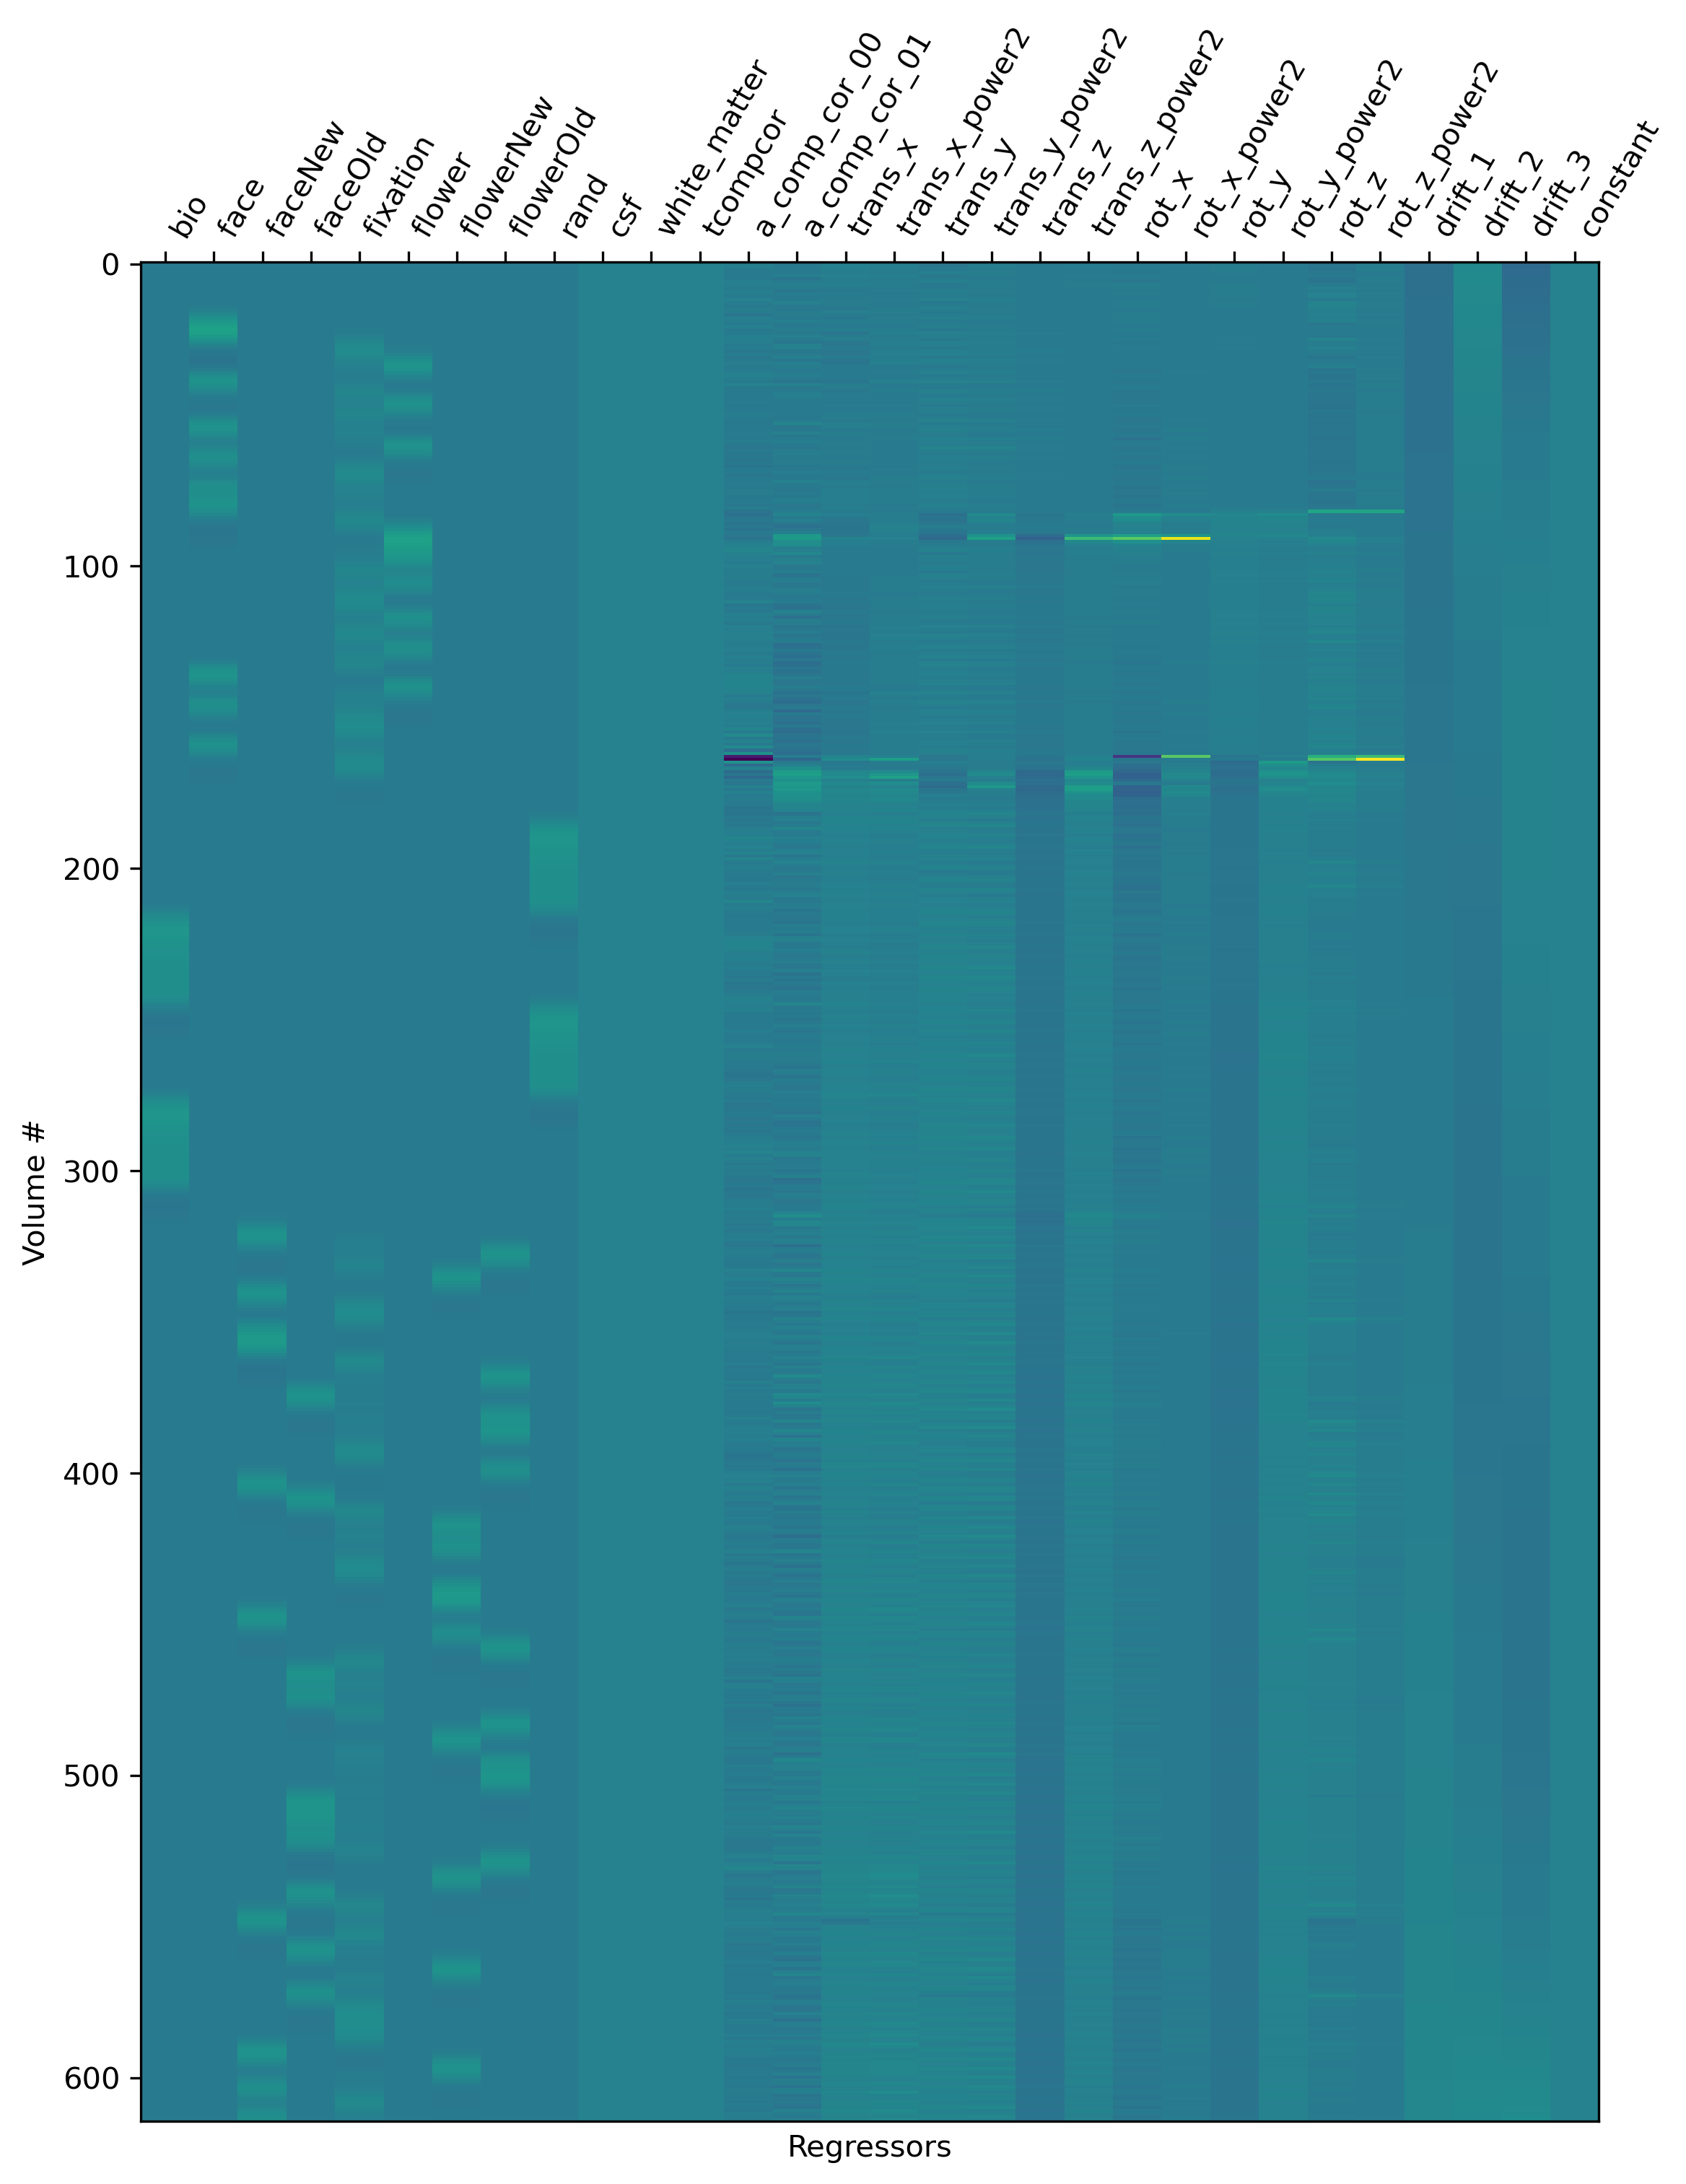

In [4]:
# Example design matrix (from 1st run of 1st subject from task of interest)
plot_design_matrix(first_level_models[0].design_matrices_[0])
plt.xlabel('Regressors')
plt.ylabel('Volume #')
plt.show();

## Plot subset of first-level results

This is an example contrast computed from the fixed-effects across runs (if multiple) from the first 3 subjects. 

/home/ajg3eh/.local/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


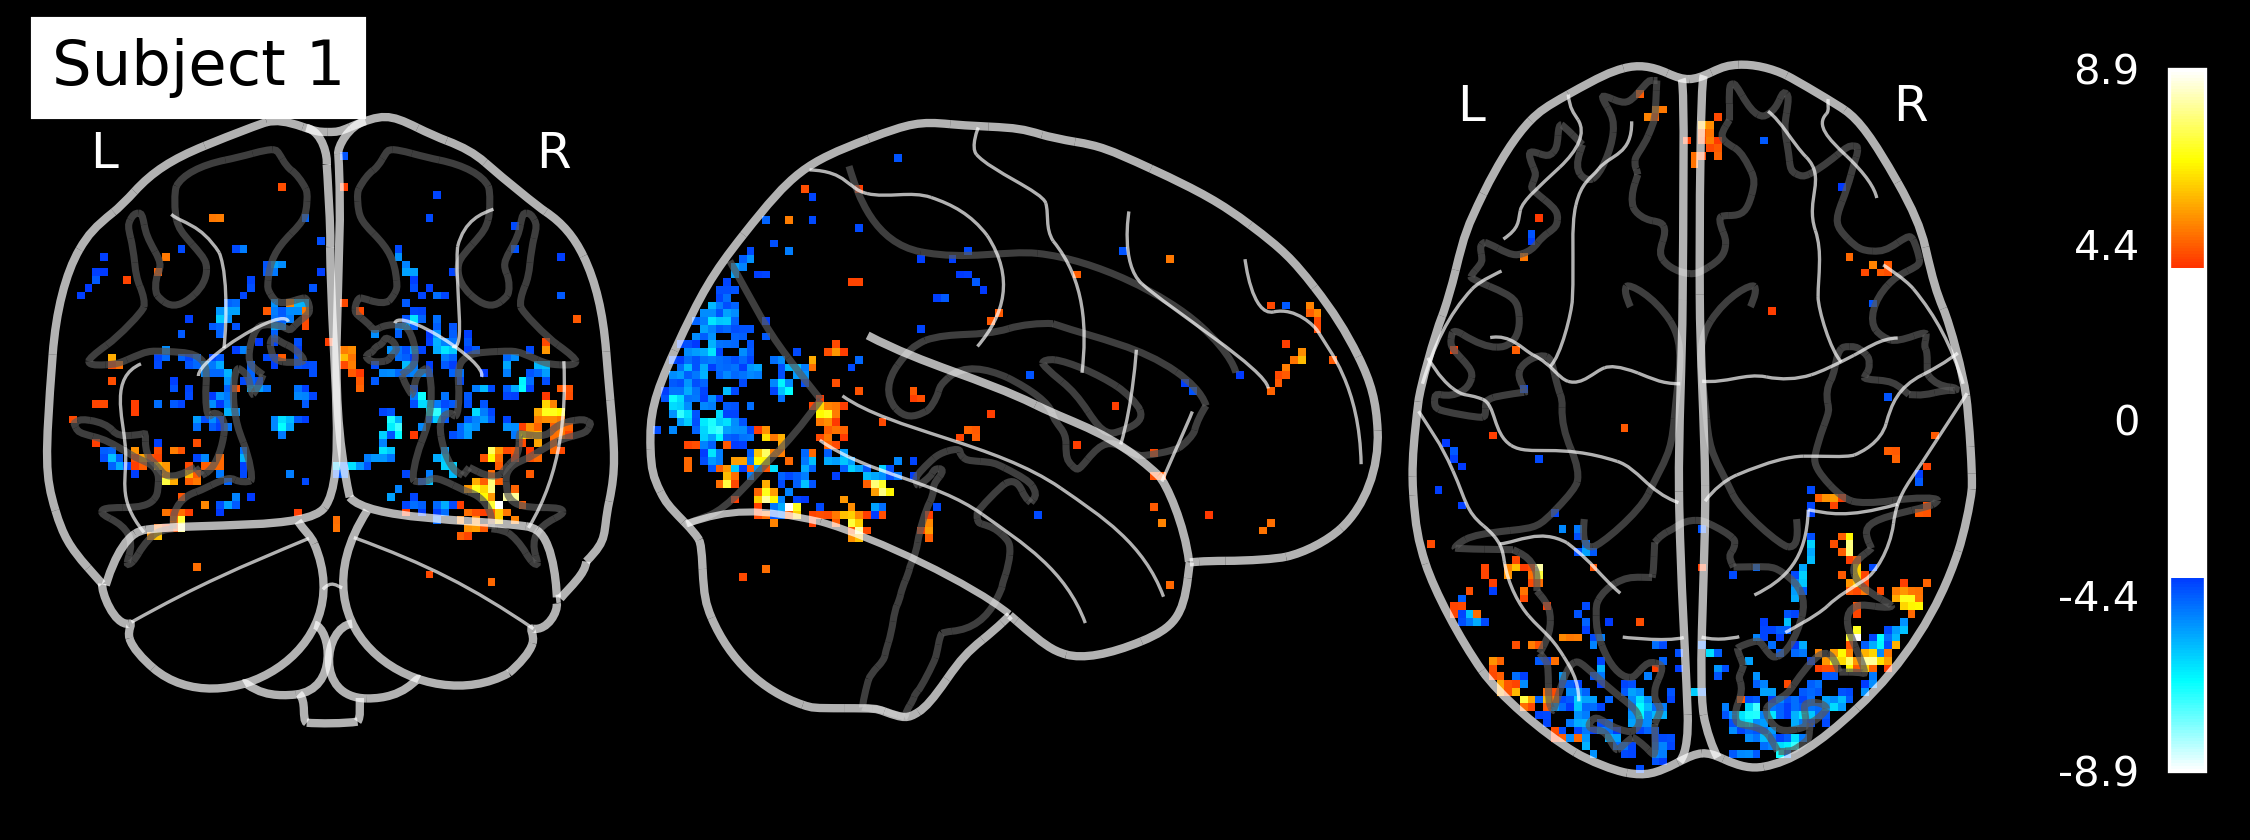

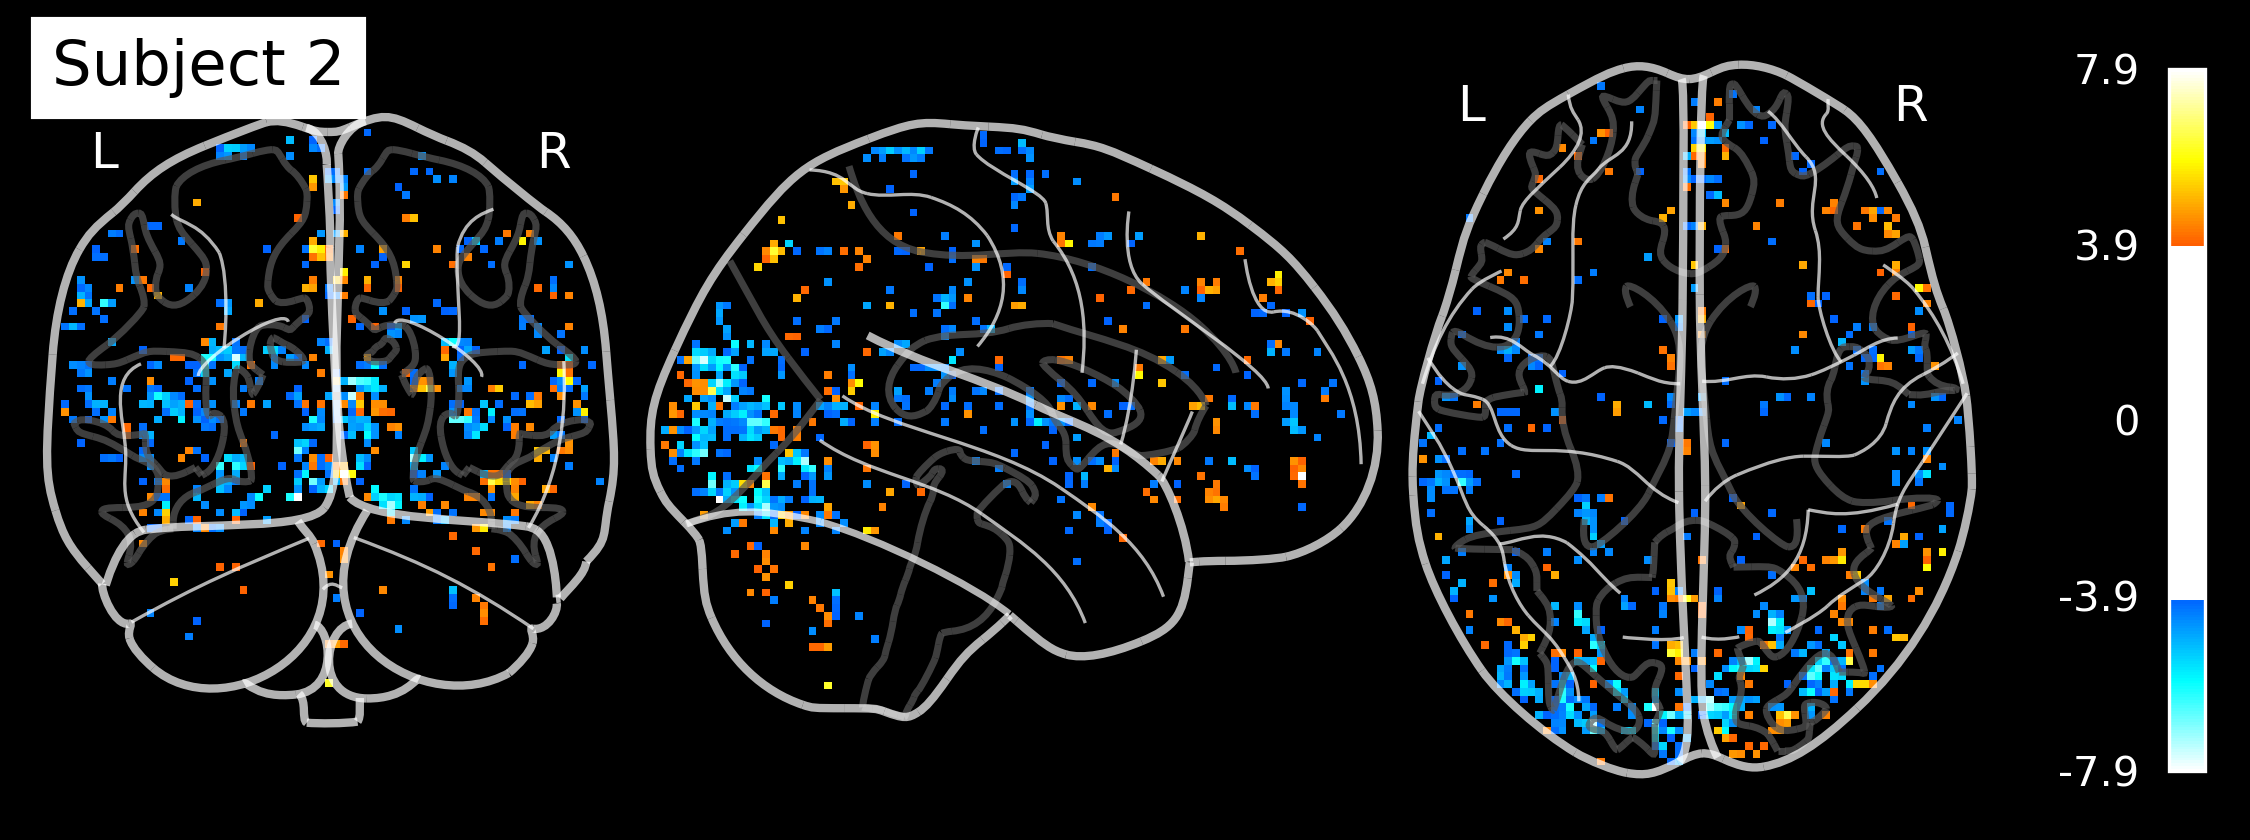

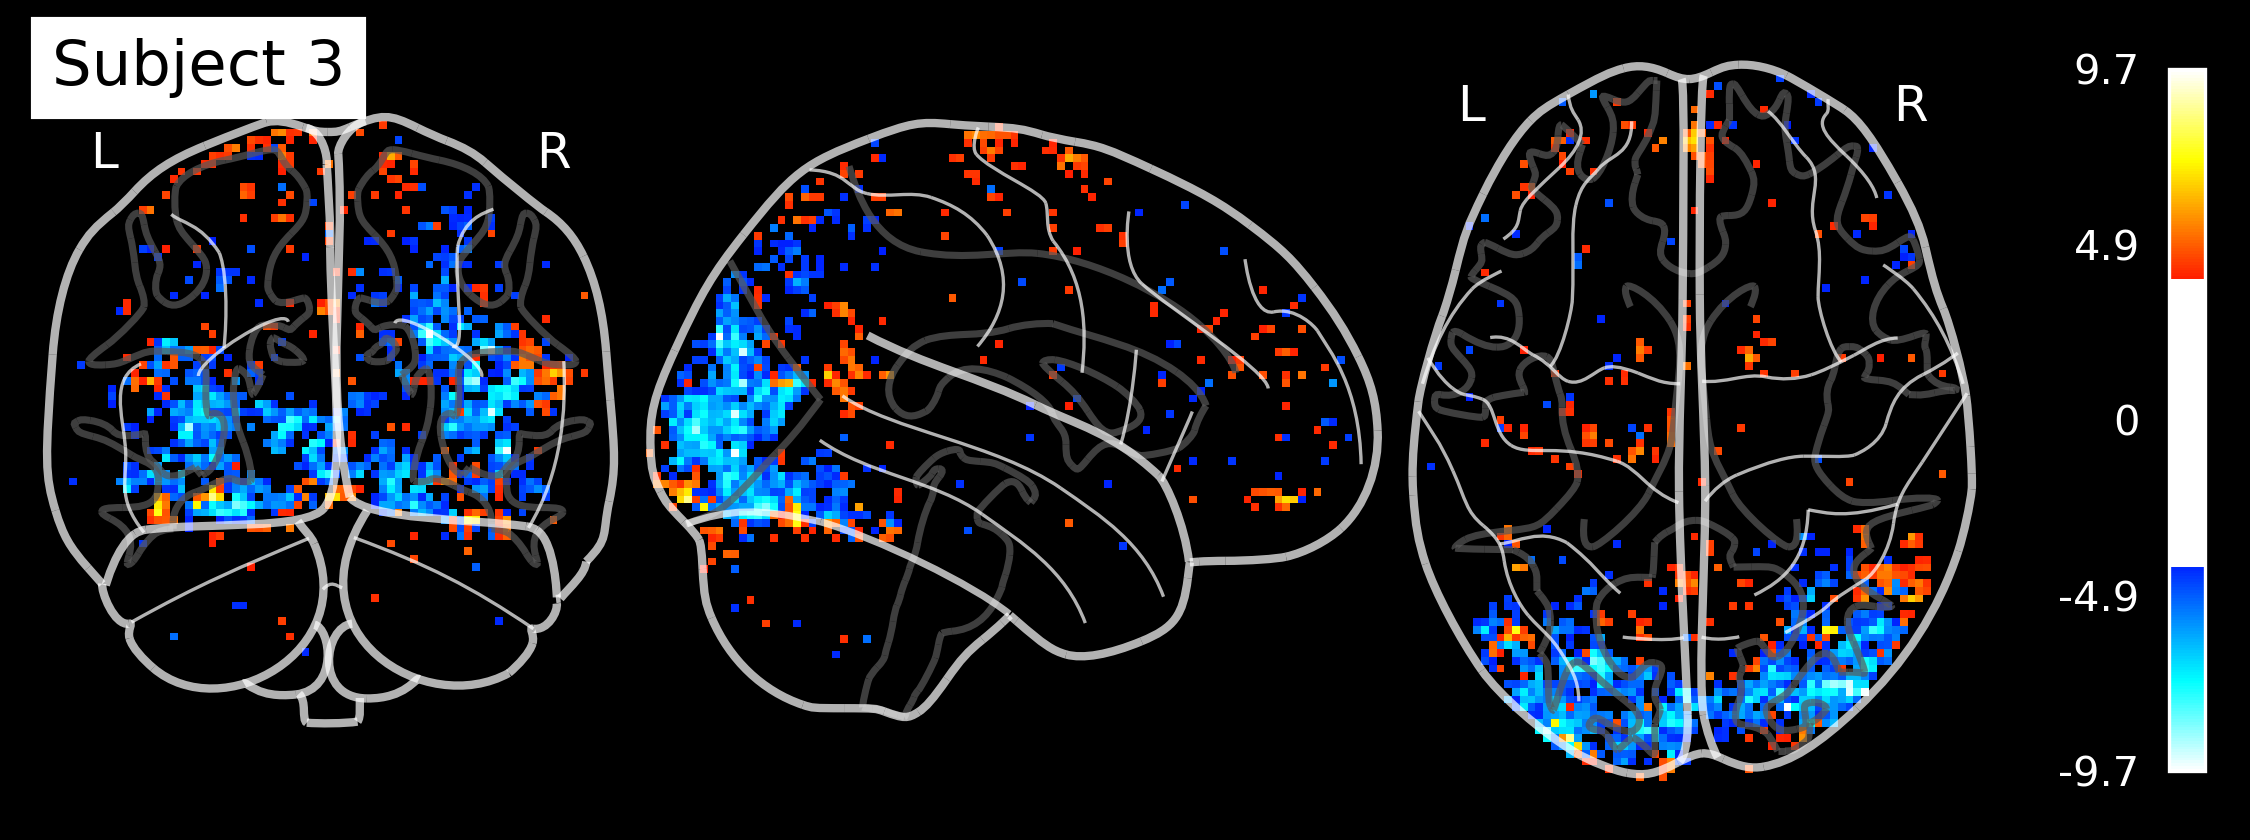

In [5]:
for idx, first_level_model in enumerate(first_level_models[0:3]):
    zmap = first_level_model.compute_contrast('face-flower')
    plot_glass_brain(zmap, colorbar=True, title=f'Subject {idx+1}',
                     threshold=4, plot_abs=False, display_mode='ortho',
                     black_bg=True)
    plt.show();

## Bonus: Fit single-trial $\beta$ coefficients

Single-trial GLM $\beta$ coefficients can be useful for decoding [multivariate pattern analysis (MVPA)] and task-based connectivity [least-squares all (LSA)]. Here, each individual trial gets its own individual column in the design matrix. For more information, see the tutorial (existed as of 10/22) titled [Beta-Series Modeling for Task-Based Functional Connectivity and Decoding](https://nilearn.github.io/dev/auto_examples/07_advanced/plot_beta_series.html). Note that while this code iterates through runs, this will still work with single-run tasks, because the outputs from the *first_level_from_bids* function (models, images, events, confounds) are iterable lists, even if that list is length 1.

In [ ]:
# Controls whether or not single-trial first level models should be fit
if also_fit_single_trial_betas:
    
    # Zip together same model inputs as previous first-level GLMs
    model_args = zip(models, models_run_imgs, models_events, models_confounds)

    # Container of all beta series for all subjects
    subj_beta_maps = {}
    
    print(f'Fitting single-trial single-subject GLMs for {task_label} task: \n')
    # Iterate through all subjects and runs
    for model, imgs, events, confounds in model_args:

        # Assumes all runs within a subject have same possible trial types
        conditions = events[0]['trial_type'].unique()
        # Single subject beta map container
        lsa_beta_maps = {cond: [] for cond in conditions}

        # Iterate through the runs to get unique trial names
        # and transform the design matrices for LSA
        for run_idx, lsa_ev in enumerate(events):

            # Initiate a counter for trials
            condition_counter = {c: 0 for c in conditions}
            # Iterate through the single-trial events
            for i_trial, trial in lsa_ev.iterrows():
                # Get current trial type
                trial_condition = trial['trial_type']
                # Add to counter increment
                condition_counter[trial_condition] += 1
                # Unique delimiter here (__) not in original condition names
                trial_name = f'{trial_condition}__' \
                    f'{condition_counter[trial_condition]}'
                # Rename conditions as individual trials
                lsa_ev.loc[i_trial, 'trial_type'] = trial_name
            # Extract all the unique trial names
            trialwise_conditions = lsa_ev['trial_type'].unique()

            # Fit runs separately for each subject
            # No run fixed effects because trials are treated independently
            model.fit(imgs[run_idx], lsa_ev, confounds[run_idx])

            # Within each run, iterate through trials
            for condition in trialwise_conditions:
                # Get the regression coefficients for current trial
                beta_map = model.compute_contrast(condition, 
                                                  output_type='effect_size')
                # Drop trial number from condition name
                condition_name = condition.split('__')[0]
                # Store single-trial coefficients for beta series output
                lsa_beta_maps[condition_name].append(beta_map)

        # Concatenate the 3D maps into a 4D beta series for each condition
        subj_beta_maps[model.subject_label] = {
             # Each subject has their own collection of beta series
            name: concat_imgs(maps) for name, maps in lsa_beta_maps.items()
        }
        
        print(f'Completed fitting subject {model.subject_label}')
        
    # Save out beta-series results to file
    with open(f'single_trial_beta_series_{task_label}.pkl', 'wb') as handle:
        pickle.dump(subj_beta_maps, handle, 
                    protocol=pickle.HIGHEST_PROTOCOL)   
else:
    print('Single-trial beta series models were not requested.')

## First-level model estimation complete!

The following notebooks use the saved outputs from these first-level models. These demonstrate how to read the files back in and work with them properly in conjunction with *nilearn* functionality:

1. *second_level.ipynb* for traditional group-level analysis of fMRI data
2. *task_conn_lsa.ipynb* for task-based functional connectivity using least-squares all beta-series models
3. *decoding.ipynb* for simple applications of machine learning to predict events (stimulus, response, etc.) from voxel activity.